In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
pd.set_option('display.max_columns', 30)
data.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


In [4]:
target = 'shot_made_flag'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

Разобьем данные для предсказания и тренировки, проверим пропуски

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         30697 non-null  object 
 1   combined_shot_type  30697 non-null  object 
 2   game_event_id       30697 non-null  int64  
 3   game_id             30697 non-null  int64  
 4   lat                 30697 non-null  float64
 5   loc_x               30697 non-null  int64  
 6   loc_y               30697 non-null  int64  
 7   lon                 30697 non-null  float64
 8   minutes_remaining   30697 non-null  int64  
 9   period              30697 non-null  int64  
 10  playoffs            30697 non-null  int64  
 11  season              30697 non-null  object 
 12  seconds_remaining   30697 non-null  int64  
 13  shot_distance       30697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           30697 non-null  object 
 16  shot

In [6]:
pred_data = data.loc[np.isnan(data['shot_made_flag'])]

In [7]:
prov_data = pd.concat([data, pred_data]).drop_duplicates(keep=False)

In [8]:
prov_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25697 entries, 1 to 30696
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   action_type         25697 non-null  object 
 1   combined_shot_type  25697 non-null  object 
 2   game_event_id       25697 non-null  int64  
 3   game_id             25697 non-null  int64  
 4   lat                 25697 non-null  float64
 5   loc_x               25697 non-null  int64  
 6   loc_y               25697 non-null  int64  
 7   lon                 25697 non-null  float64
 8   minutes_remaining   25697 non-null  int64  
 9   period              25697 non-null  int64  
 10  playoffs            25697 non-null  int64  
 11  season              25697 non-null  object 
 12  seconds_remaining   25697 non-null  int64  
 13  shot_distance       25697 non-null  int64  
 14  shot_made_flag      25697 non-null  float64
 15  shot_type           25697 non-null  object 
 16  shot

In [9]:
cat = []
num = []

for x in prov_data.columns:
    if data.dtypes[x]=='object':
        cat.append(x)
    else:
        num.append(x)

Посмотрим, что из себя представляют признаки

In [10]:
prov_data.describe()

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,25697.000000,2.569700e+04,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,25697.000000,2.569700e+04,25697.000000
mean,249.348679,2.474109e+07,33.953043,7.148422,91.257345,-118.262652,4.886796,2.520800,0.146243,28.311554,13.457096,0.446161,1.610613e+09,15328.166946
std,149.778520,7.738108e+06,0.088152,110.073147,88.152106,0.110073,3.452475,1.151626,0.353356,17.523392,9.388725,0.497103,0.000000e+00,8860.462397
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,2.000000
25%,111.000000,2.050006e+07,33.884300,-67.000000,4.000000,-118.336800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7646.000000
50%,253.000000,2.090034e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15336.000000
75%,367.000000,2.960027e+07,34.040300,94.000000,160.000000,-118.175800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,22976.000000
max,653.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


In [11]:
for x in cat:
        print(x)
        print(prov_data[x].unique())
        print('\n')

action_type
['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 

С уверенностью исключим из признаков все айди и team_name(команда одна); из двух колонок с названиями бросков оставить можно одну, могу предположить, что обобщенных категорий в combined_shot_type будет достаточно; season и matchup повторяют информацию из game_date и opponent, поэтому удаляем по одному из пары; значения shot_distance объединены в категории shot_zone_range, количественный признак удалим

О shot_type, shot_zone_area, shot_zone_basic, shot_zone_range сказать нечего, оставляем

In [12]:
for x in ['team_name', 'action_type', 'game_date', 'matchup']:
    cat.remove(x)
print(cat, sep='')

['combined_shot_type', 'season', 'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range', 'opponent']


In [13]:
for x in ['game_event_id', 'game_id', 'team_id', 'shot_id', 'shot_distance']:
    num.remove(x)
print(num, sep='')

['lat', 'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs', 'seconds_remaining', 'shot_made_flag']


В количественных признаках остались фичи, отвечающие за время бросков и предположительно связанные с местом, откуда они были сделаны, первые оставляем, вторые рассмотрим

Еще остался одинокий признак playoffs, проверим его корреляцию с таргетом напрямую

In [14]:
prov_data[['playoffs',target]].corr()

,playoffs,shot_made_flag
playoffs,1.000000,-0.001257
shot_made_flag,-0.001257,1.000000


Вердикт: дропаем

In [15]:
num.remove('playoffs')

Количественных признаков осталось мало, может посмотреть pairplot

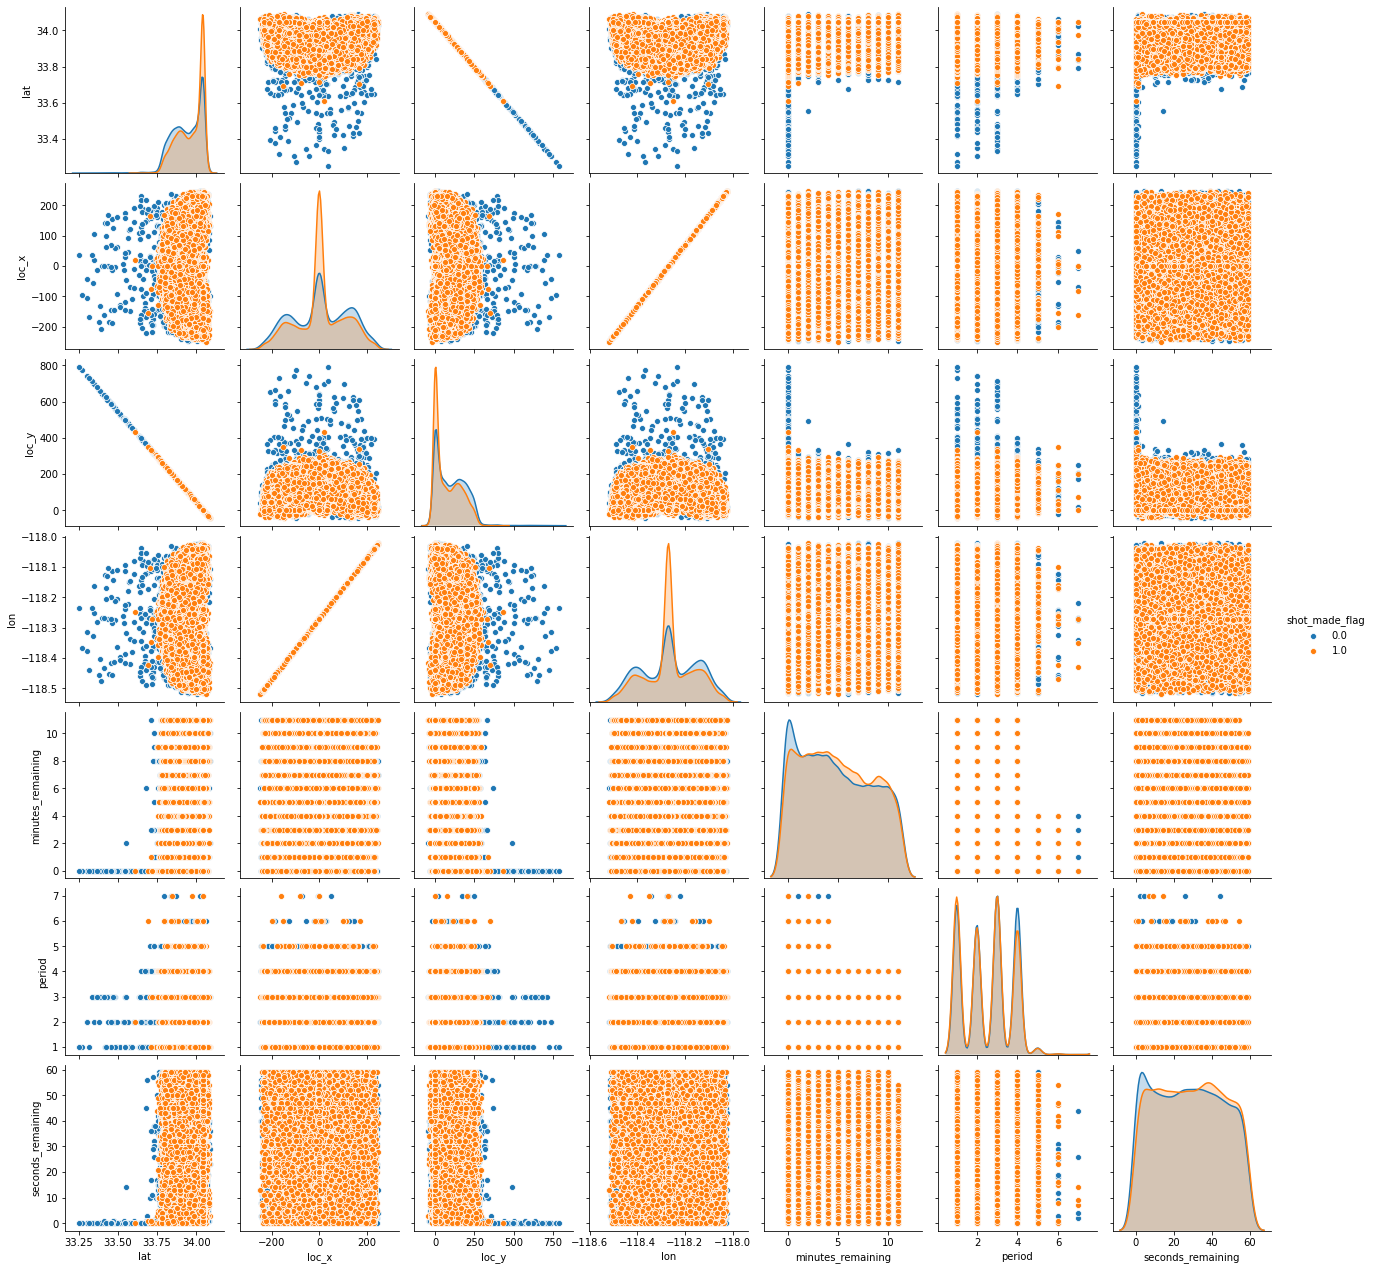

In [16]:
sns.pairplot(prov_data[num], hue=target)

Единственное, про что можно с уверенностью сказать по этим графикам: lat и lon полностью дублирует loс_x и loc_y, так что оставляем одну пару

In [17]:
num.remove('lat')
num.remove('lon')

Посмотрим на таргет

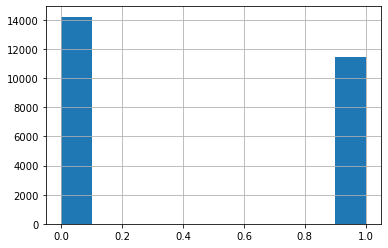

In [18]:
prov_data[target].hist()

Обрабатывать никак не будем

Теперь проверим наличие выбросов, признаков очень мало, поэтому вручную посмотрим по графикам

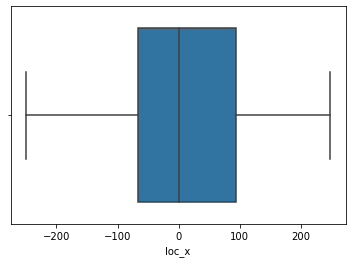

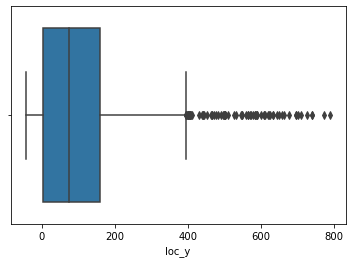

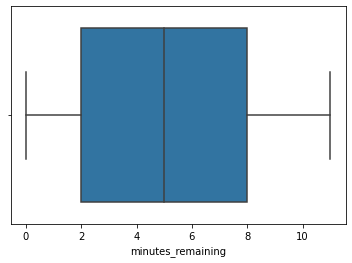

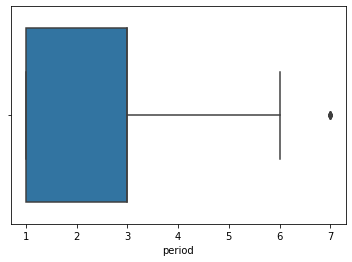

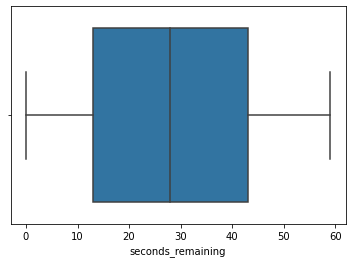

In [19]:
for x in num[:-1]:
    plt.show(sns.boxplot(prov_data[x]))

Уберем единственное выбивающееся значение периода

In [20]:
prov_data['period'] = prov_data['period'].clip(1,6)

В loc_y много значений, определенных как выбросы, присмотримся

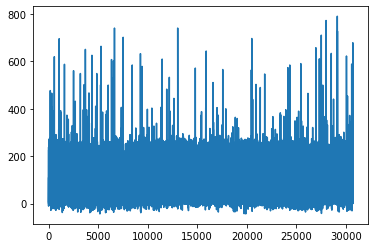

In [21]:
prov_data['loc_y'].plot()

Значения не похожи на ошибки, скорее, это просто более редкие позиции, причем все в диапазоне 400-800, т.е. отклонение в большую сторону, поэтому, если мы хотим их как-то обработать, можем заменить их на максимум - край усика боксплота

In [22]:
prov_data['loc_y'].where(prov_data['loc_y']<400, other=400, inplace=True)

Категориальные переменные мы уже просматривали выше, никаких неестественных значений не было обнаружено

Попробуем найти дополнительные комбинированные признаки

In [23]:
X_data = prov_data[cat+num].drop(columns=target)

In [24]:
dict_ = {}
i = 0
nn = range(25)

for x in X_data.columns.values:
    dict_[x] = 'x' + str(nn[i])
    i+=1
dict_

{'combined_shot_type': 'x0',
 'season': 'x1',
 'shot_type': 'x2',
 'shot_zone_area': 'x3',
 'shot_zone_basic': 'x4',
 'shot_zone_range': 'x5',
 'opponent': 'x6',
 'loc_x': 'x7',
 'loc_y': 'x8',
 'minutes_remaining': 'x9',
 'period': 'x10',
 'seconds_remaining': 'x11'}

In [25]:
poly = PolynomialFeatures(2)
X = pd.get_dummies(X_data)
X = poly.fit_transform(X)
y = prov_data[target]

In [26]:
model = linear_model.LogisticRegression(solver='liblinear').fit(X,y)
model.score(X, y)

0.6179320543254077

In [27]:
weights = dict(zip(model.coef_[0], poly.get_feature_names()))
weights = sorted(weights.items())
weights[-10:]

[(0.017735641725581144, 'x2 x23'),
 (0.019710319272130298, 'x1 x6'),
 (0.0203787240827048, 'x2 x57'),
 (0.022031088776364446, 'x4 x5'),
 (0.022173210671131056, 'x2 x75'),
 (0.023445471004157042, 'x2'),
 (0.02745413761686792, 'x2 x44'),
 (0.038731999899225364, 'x3 x6'),
 (0.04318463956842161, 'x4 x6'),
 (0.05489721138955956, 'x2 x6')]

Ни один из вариантов не выглядит обоснованным
Запустим модель на имеющихся признаках

In [28]:
num.remove(target)

In [29]:
X = prov_data[cat+num]
X = pd.get_dummies(X)
y = prov_data[target]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)

In [31]:
model = linear_model.LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.6156939040207523

In [32]:
model = linear_model.Lasso(alpha=0.1)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.018540399214617698

Коэффициенты L1, L2 регуляризации

In [70]:
X_Scaler = StandardScaler().fit_transform(X)

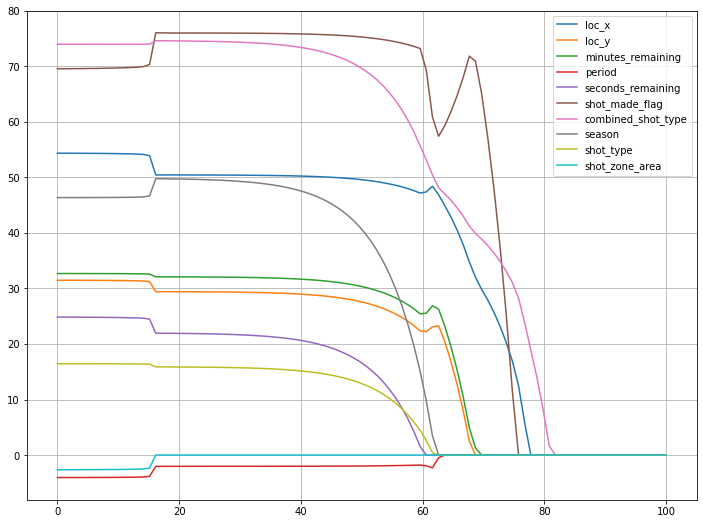

In [241]:
model = linear_model.Lasso().fit(X_Scaler, y)

coefs = []
alphas = list(2**np.linspace(-10,10,100))

for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

plt.figure(figsize=(12,9))
x = np.linspace(0,len(coefs),len(coefs))
for i in np.vstack(coefs).T:
    plt.plot(x,np.sign(i)*np.abs(i)) 
plt.legend(num+cat)      
plt.grid()

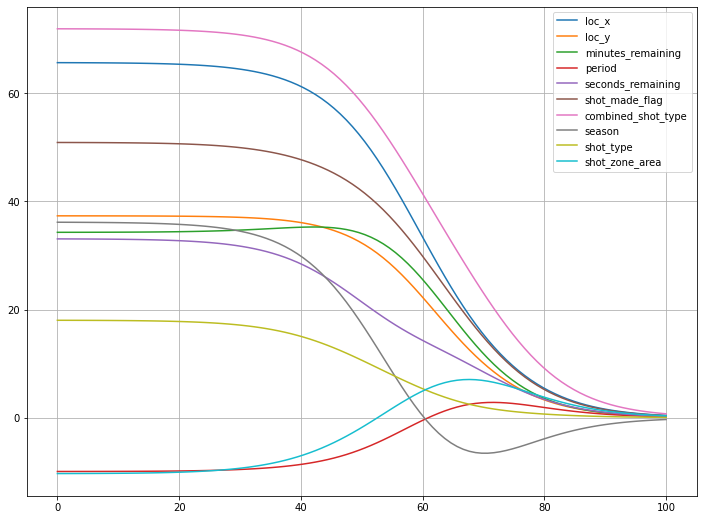

In [245]:
model = linear_model.Ridge().fit(X_Scaler, y)

coefs = []
alphas = list(2**np.linspace(-10,10,100))

for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)

plt.figure(figsize=(12,9))
x = np.linspace(0,len(coefs),len(coefs))
for i in np.vstack(coefs).T:
    plt.plot(x,np.sign(i)*np.abs(i)) 
plt.legend(num+cat)      
plt.grid()

Быстрее всех зануляются: shot_type, shot_zone_area, period и seconds_remaining

Наиболее позднее зануление, как и ожидалось у признака combined_shot_type